In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip /content/drive/MyDrive/Thesis/preprocessed-data-WlASL_WLASL_300.zip

Archive:  /content/drive/MyDrive/Thesis/preprocessed-data-WlASL_WLASL_300.zip
   creating: preprocessed-data-WlASL_WLASL_300/
   creating: preprocessed-data-WlASL_WLASL_300/brown/
  inflating: preprocessed-data-WlASL_WLASL_300/brown/07972.parquet  
  inflating: preprocessed-data-WlASL_WLASL_300/brown/07973.parquet  
  inflating: preprocessed-data-WlASL_WLASL_300/brown/65263.parquet  
  inflating: preprocessed-data-WlASL_WLASL_300/brown/67446.parquet  
  inflating: preprocessed-data-WlASL_WLASL_300/brown/69028.parquet  
  inflating: preprocessed-data-WlASL_WLASL_300/brown/69252.parquet  
  inflating: preprocessed-data-WlASL_WLASL_300/brown/70242.parquet  
   creating: preprocessed-data-WlASL_WLASL_300/brush/
  inflating: preprocessed-data-WlASL_WLASL_300/brush/08000.parquet  
  inflating: preprocessed-data-WlASL_WLASL_300/brush/08001.parquet  
  inflating: preprocessed-data-WlASL_WLASL_300/brush/08002.parquet  
  inflating: preprocessed-data-WlASL_WLASL_300/brush/08005.parquet  
  infla

In [2]:
!unzip /content/drive/MyDrive/Thesis/landmarks_files_alphabatically_WLASL_300.zip

Archive:  /content/drive/MyDrive/Thesis/landmarks_files_alphabatically_WLASL_300.zip
   creating: landmarks_files_(alphabatically)_WLASL_300/
   creating: landmarks_files_(alphabatically)_WLASL_300/a/
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/00295.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/01610.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/01611.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/01612.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/01613.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/01614.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/01615.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/66039.parquet  
   creating: landmarks_files_(alphabatically)_WLASL_300/a lot/
  inflating: landmarks_files_(alphabatically)_WLASL_300/a lot/02123.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a lot/0212

In [7]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import random
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Reshape, Conv1D, BatchNormalization, DepthwiseConv1D, MaxPool1D, GlobalAvgPool1D, Dropout, Dense
from tensorflow.keras import layers, optimizers

In [8]:
UNITS = 256 # Transformer

# Transformer
NUM_BLOCKS = 4
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.40
CLASSIFIER_DROPOUT_RATIO = 0.20

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)

# Activations
GELU = tf.keras.activations.gelu

N_EPOCHS = 200
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
NUM_CLASSES = 300 # Class avalable in WlASL_300

In [9]:
# load data
features = np.load("/content/preprocessed-data-WlASL_WLASL_300/feature_data.npy")
labels = np.load("/content/preprocessed-data-WlASL_WLASL_300/feature_labels.npy")
print(features.shape, labels.shape)

(3185, 30, 104, 3) (3185,)


In [10]:
# train test split
train_x, val_x, train_y, val_y = train_test_split(features, labels, test_size=0.20, random_state=42)

In [11]:
print(f"Validation X: {val_x.shape}, Validation Y: {val_y.shape}")
print(f"Training X: {train_x.shape}, Training Y: {train_y.shape}")

Validation X: (637, 30, 104, 3), Validation Y: (637,)
Training X: (2548, 30, 104, 3), Training Y: (2548,)


In [12]:
def scaled_dot_product(q, k, v, softmax):
    # Calculates Q . K(transpose)
    qkt = tf.matmul(q, k, transpose_b=True)
    # Calculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1], dtype=tf.float32))
    scaled_qkt = qkt / dk
    softmax_output = softmax(scaled_qkt)

    z = tf.matmul(softmax_output, v)
    # Shape: (m, Tx, depth), same shape as q, k, v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_of_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model // num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()

    def call(self, x):
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q, K, V, self.softmax))
        multi_head = tf.concat(multi_attn, axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
        self.mhas = []
        self.mlps = []

        for i in range(self.num_blocks):
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(0.30),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))

    def call(self, x):
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x)
            x = x + mlp(x)

        return x

In [13]:
def dense_block(units):
    fc = layers.Dense(units)
    norm = layers.LayerNormalization()
    act = layers.Activation("gelu")
    drop = layers.Dropout(0.10)
    return lambda x: drop(act(norm(fc(x))))

In [14]:
class Augmentation(tf.keras.layers.Layer):
    def __init__(self, noise_std):
        super(Augmentation, self).__init__()
        self.noise_std = noise_std

    def add_noise(self, t):
        B = tf.shape(t)[0]
        return tf.where(
            t == 0.0,
            0.0,
            t + tf.random.normal([B,1,1,tf.shape(t)[3]], 0, self.noise_std),
        )

    def call(self, lips0, left_hand0, pose0, right_hand0, training=False):
        if training:
            # Lips
            lips0 = self.add_noise(lips0)
            # Left Hand
            left_hand0 = self.add_noise(left_hand0)
            # Pose
            pose0 = self.add_noise(pose0)
            # right Hand
            right_hand0 = self.add_noise(right_hand0)

        return lips0, left_hand0, pose0, right_hand0

In [15]:
inputs = tf.keras.Input(shape=(30, 104, 3))

# inputs = augment_fn(inputs_l, max_len=30)
lips = layers.Lambda(lambda x: tf.slice(x, [0, 0, 0, 0], [-1, 30, 40, 3]))(inputs)
lh = layers.Lambda(lambda x: tf.slice(x, [0, 0, 40, 0], [-1, 30, 21, 3]))(inputs)
po = layers.Lambda(lambda x: tf.slice(x, [0, 0, 61, 0], [-1, 30, 22, 3]))(inputs)
rh = layers.Lambda(lambda x: tf.slice(x, [0, 0, 83, 0], [-1, 30, 21, 3]))(inputs)

augmentation_layer = Augmentation(noise_std=0.1)
lips, lh, po, rh = augmentation_layer(lips, lh, po, rh, training=True)


lips = tf.keras.layers.Reshape((30, 40*3))(lips)
lh = tf.keras.layers.Reshape((30, 21*3))(lh)
po = tf.keras.layers.Reshape((30, 22*3))(po)
rh = tf.keras.layers.Reshape((30, 21*3))(rh)


embedding_units = [256, 256]

# dense encoder model
lips = Dense(512, activation="gelu")(lips)
lh = Dense(512, activation="gelu")(lh)
po = Dense(512, activation="gelu")(po)
rh = Dense(512, activation="gelu")(rh)

# Use layers.concatenate instead of tf.concat
x = layers.concatenate([lips, lh, po, rh], axis=2)  # Changed line
# x = tf.reduce_mean(x, axis=3)
for n in embedding_units:
    x = dense_block(n)(x)
x = Transformer(num_blocks=4)(x)
# Wrap tf.reduce_sum in a Lambda layer
x = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(x)  # This line is changed
dense = layers.Dense(256, activation="gelu")(x)
drop = layers.Dropout(0.1)(x)

out = layers.Dense(NUM_CLASSES, activation="softmax", name="outputs")(x)

model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 30, 104, 3)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 30, 40, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 30, 21, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 30, 22, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 30, 21, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ augmentation              │ [(None, 30, 40, 3),    │              0 │ lambda[0][0],          │
│ (Augmentation)            │ (None, 30, 21, 3),     │                │ lambda_1[0][0],        │
│                           │ (None, 30, 22, 3),     │                │ lambda_2[0][0],        │
│                           │ (None, 30, 21, 3)]     │                │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 30, 120)        │              0 │ augmentation[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 30, 63)         │              0 │ augmentation[0][1]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 30, 66)         │              0 │ augmentation[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 30, 63)         │              0 │ augmentation[0][3]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 30, 512)        │         61,952 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 30, 512)        │         32,768 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 30, 512)        │         34,304 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 30, 512)        │         32,768 │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 30, 2048)       │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 30, 256)        │        524,544 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization  

 Total params: 2,409,260 (9.19 MB)

 Trainable params: 2,409,260 (9.19 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
optimizer = tf.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-7, clipnorm= 0.25)
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    # y_true = tf.squeeze(y_true, axis=2)  # Remove this line as it's causing the error
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.35)


def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):

    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

# Learning Rate Callback
# lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[min(step, len(LR_SCHEDULE)-1)], verbose=1)
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio

    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

model.compile(optimizer=optimizer,
              loss=scce_with_ls,
              metrics=["accuracy","sparse_top_k_categorical_accuracy"])

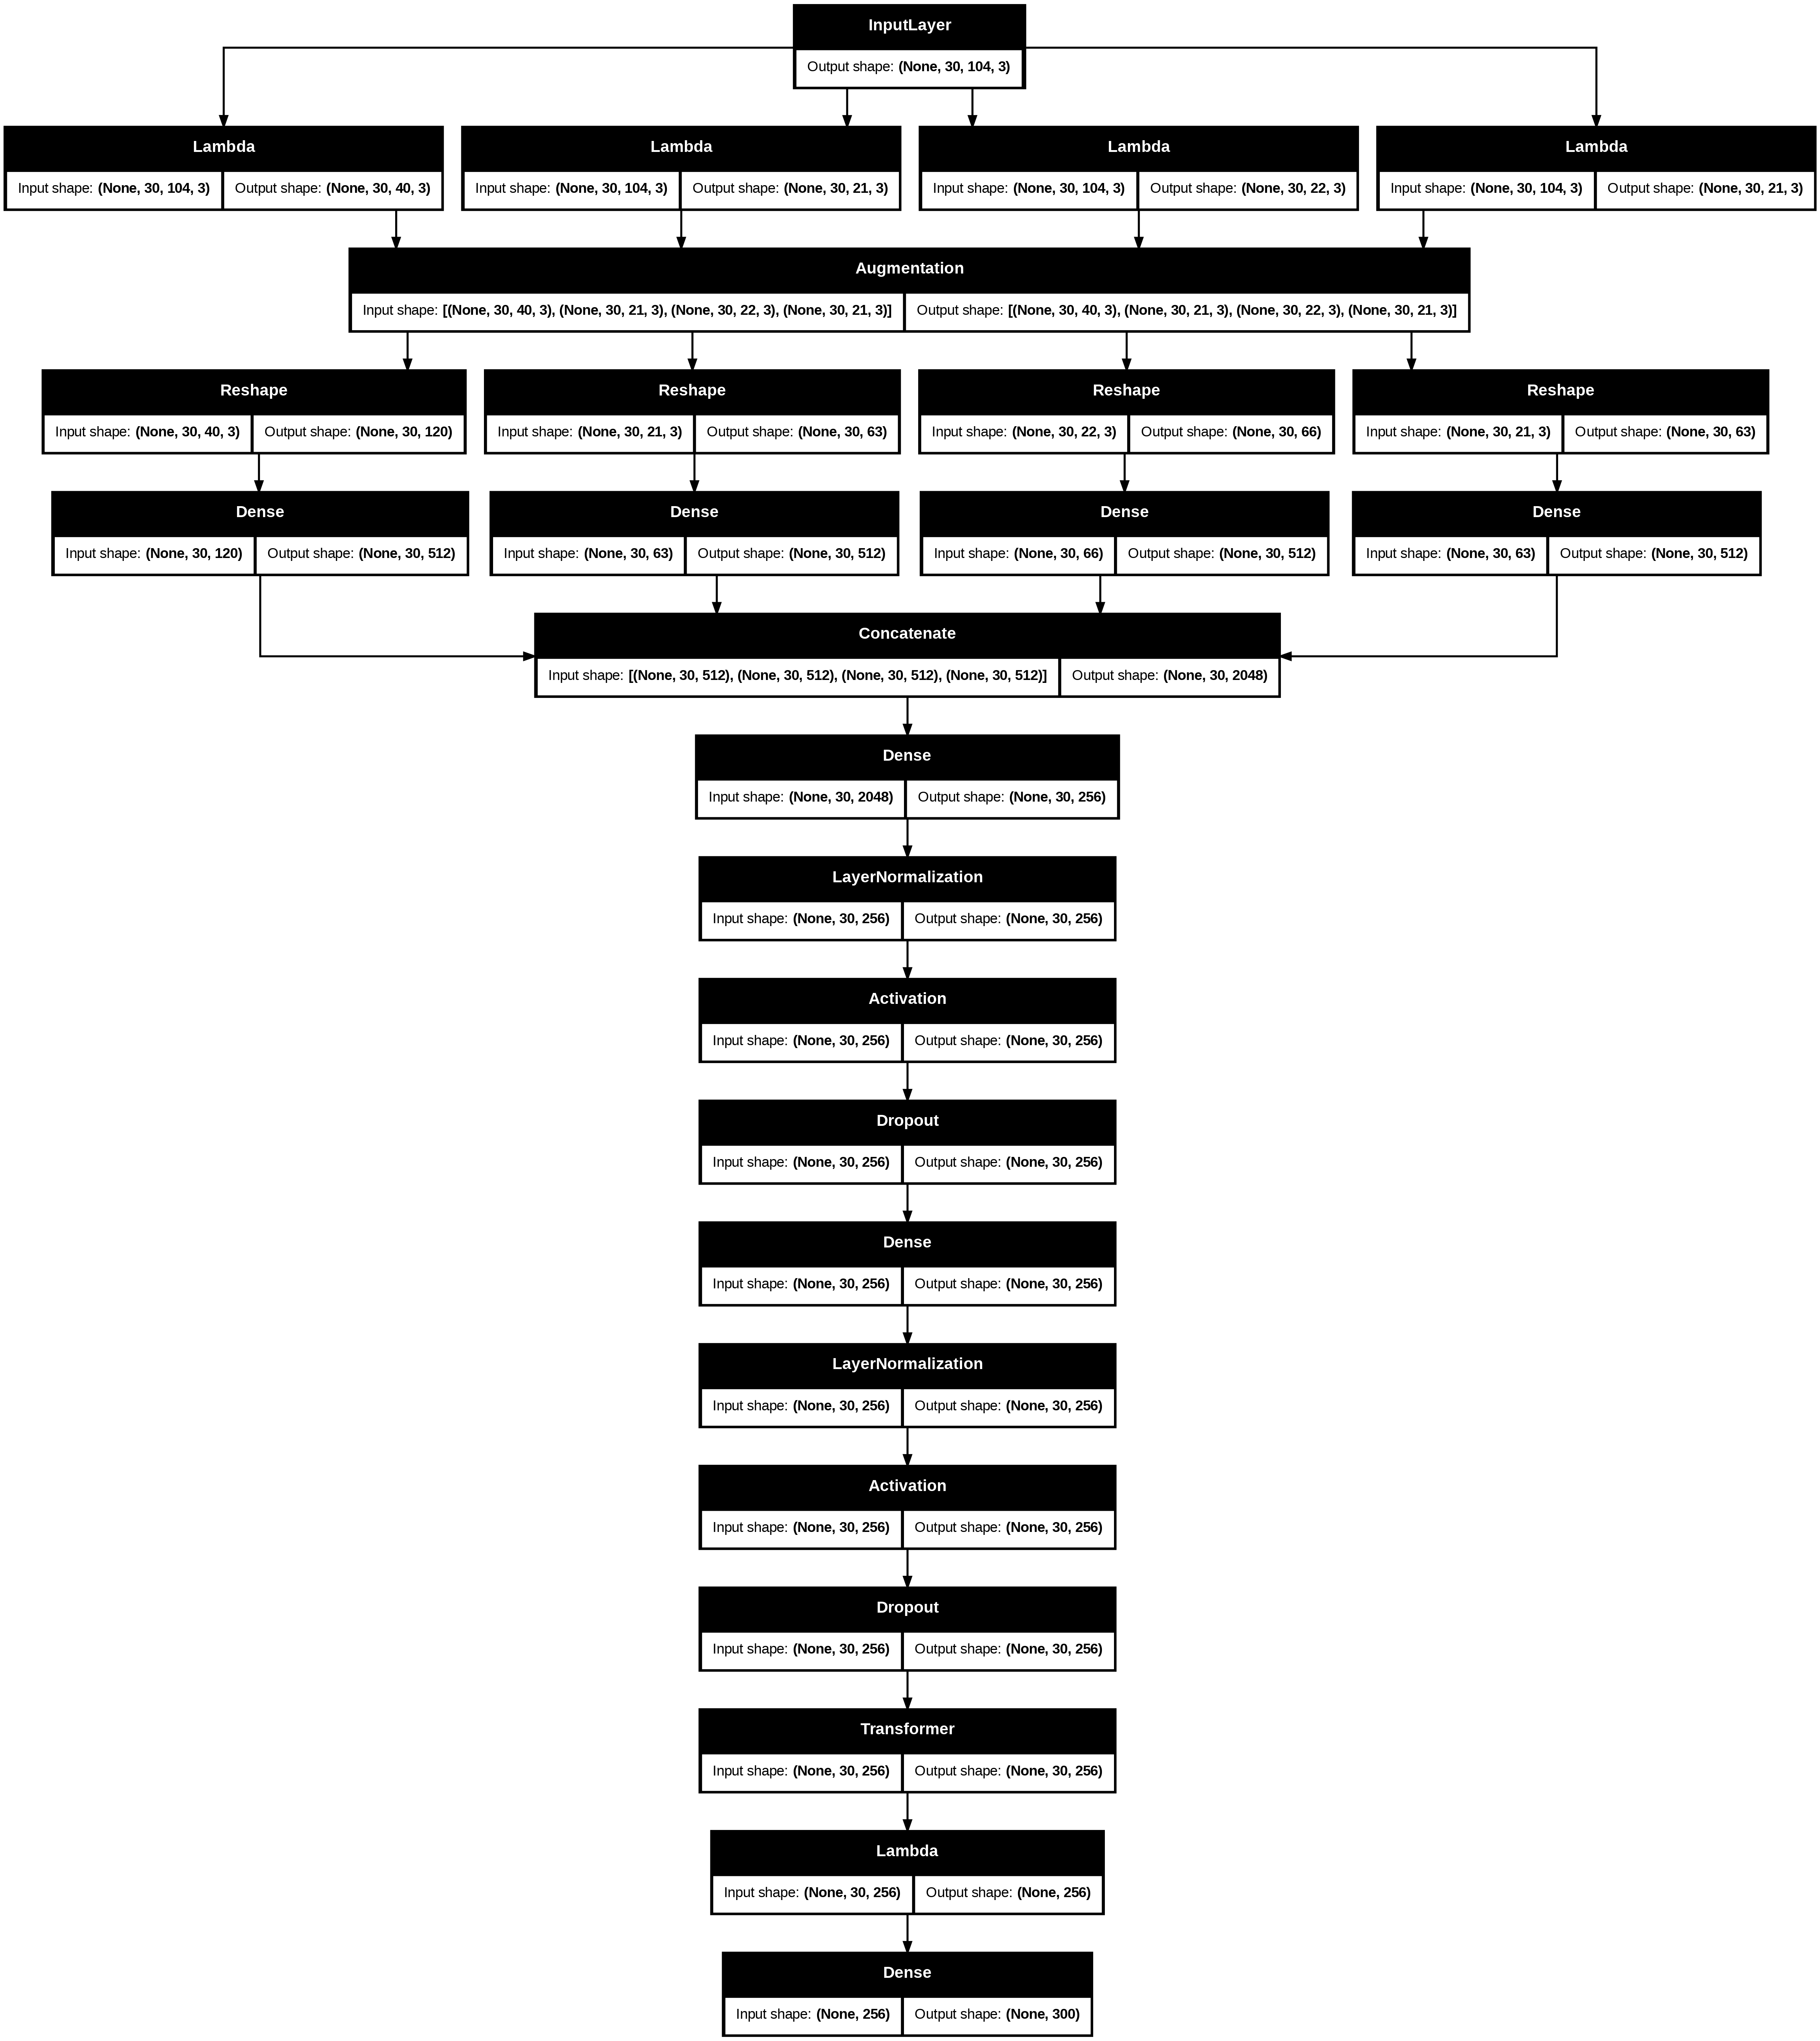

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')

In [18]:
history = model.fit(train_x, train_y, epochs=200, validation_data=(val_x, val_y), batch_size=64,
                   callbacks=[
                    lr_callback,
                    WeightDecayCallback()])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.0059 - loss: 1067.3972 - sparse_top_k_categorical_accuracy: 0.7268 - val_accuracy: 0.0016 - val_loss: 132.6503 - val_sparse_top_k_categorical_accuracy: 0.0141 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009999383162408303.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.0059 - loss: 120.3920 - sparse_top_k_categorical_accuracy: 0.0166 - val_accuracy: 0.0047 - val_loss: 104.2961 - val_sparse_top_k_categorical_accuracy: 0.0330 - learning_rate: 9.9994e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009997532801828658.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.0018 - loss: 109.7263 - sparse_top_k_categorical_accuracy: 0.0127 -

In [19]:
model.save_weights('model.weights.h5')

In [20]:
!zip -r model.zip model.png model.weights.h5

  adding: model.png (deflated 31%)
  adding: model.weights.h5 (deflated 10%)


In [33]:
!cp model.zip /content/drive/MyDrive/
!cp model.png /content/drive/MyDrive/
!cp model.weights.h5 /content/drive/MyDrive

In [21]:
save_path = '/content/'

def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None, save_path=None):
    plt.figure(figsize=(20, 10))

    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')
    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)

    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16)
    plt.yticks(fontsize=16)

    plt.legend(prop={'size': 10})
    plt.grid()

    # Generate a filename based on the metric
    if save_path is None:
        save_path = f'{metric}_plot.png'

    # Save the figure
    plt.savefig(save_path, bbox_inches='tight')

    plt.show()

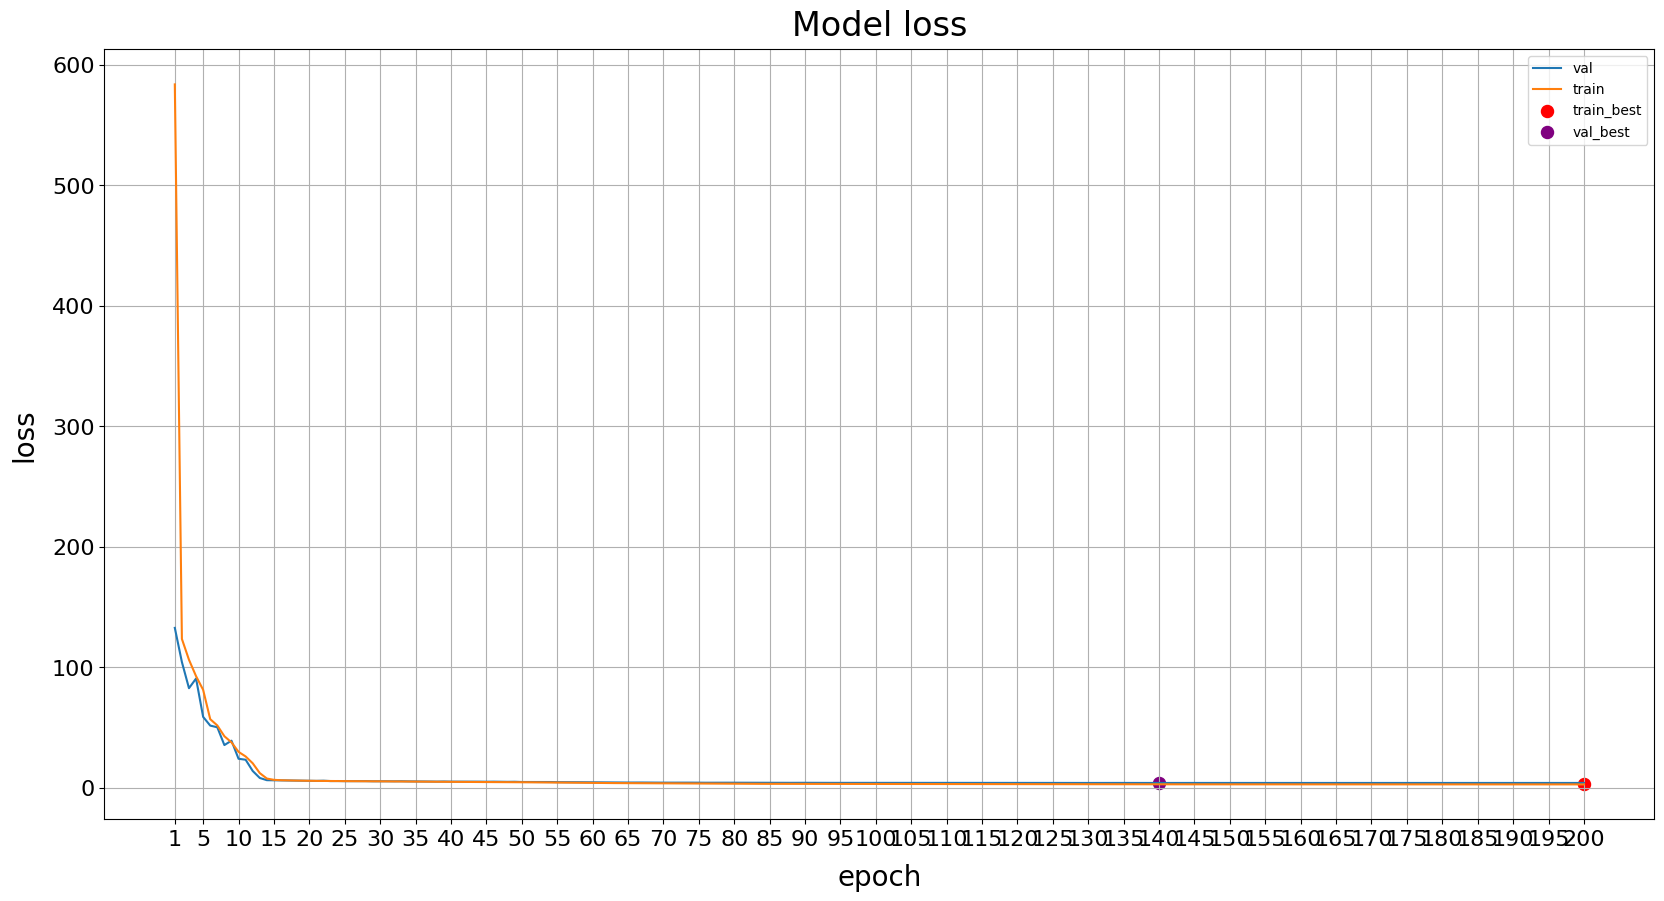

In [22]:
plot_history_metric('loss', f_best=np.argmin)

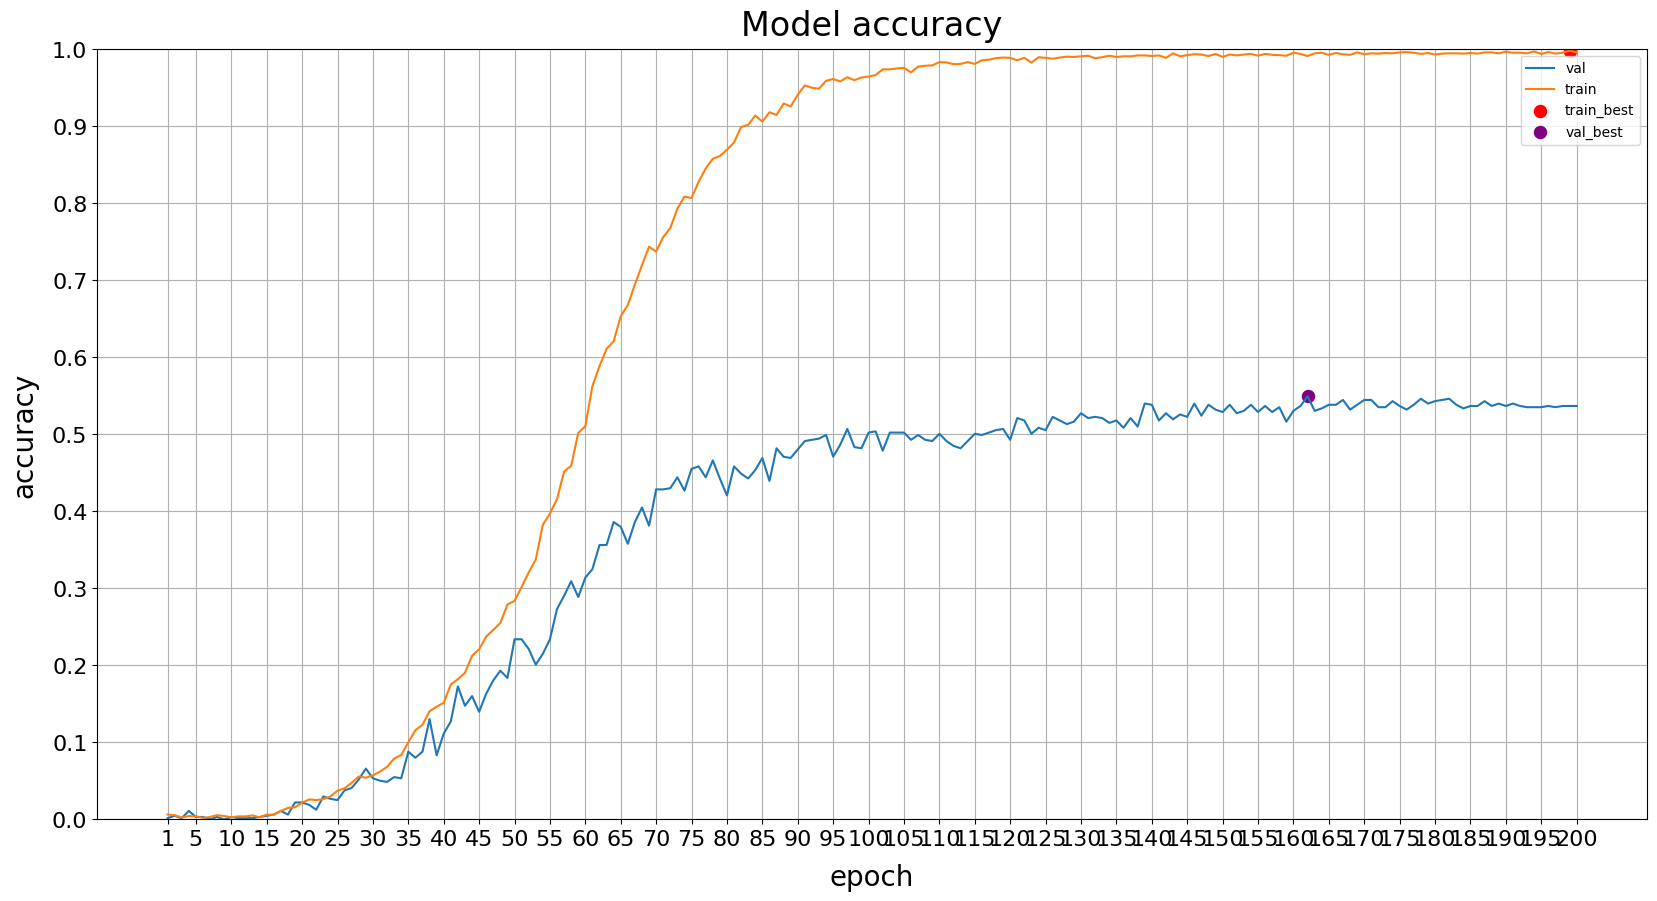

In [23]:
plot_history_metric('accuracy', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

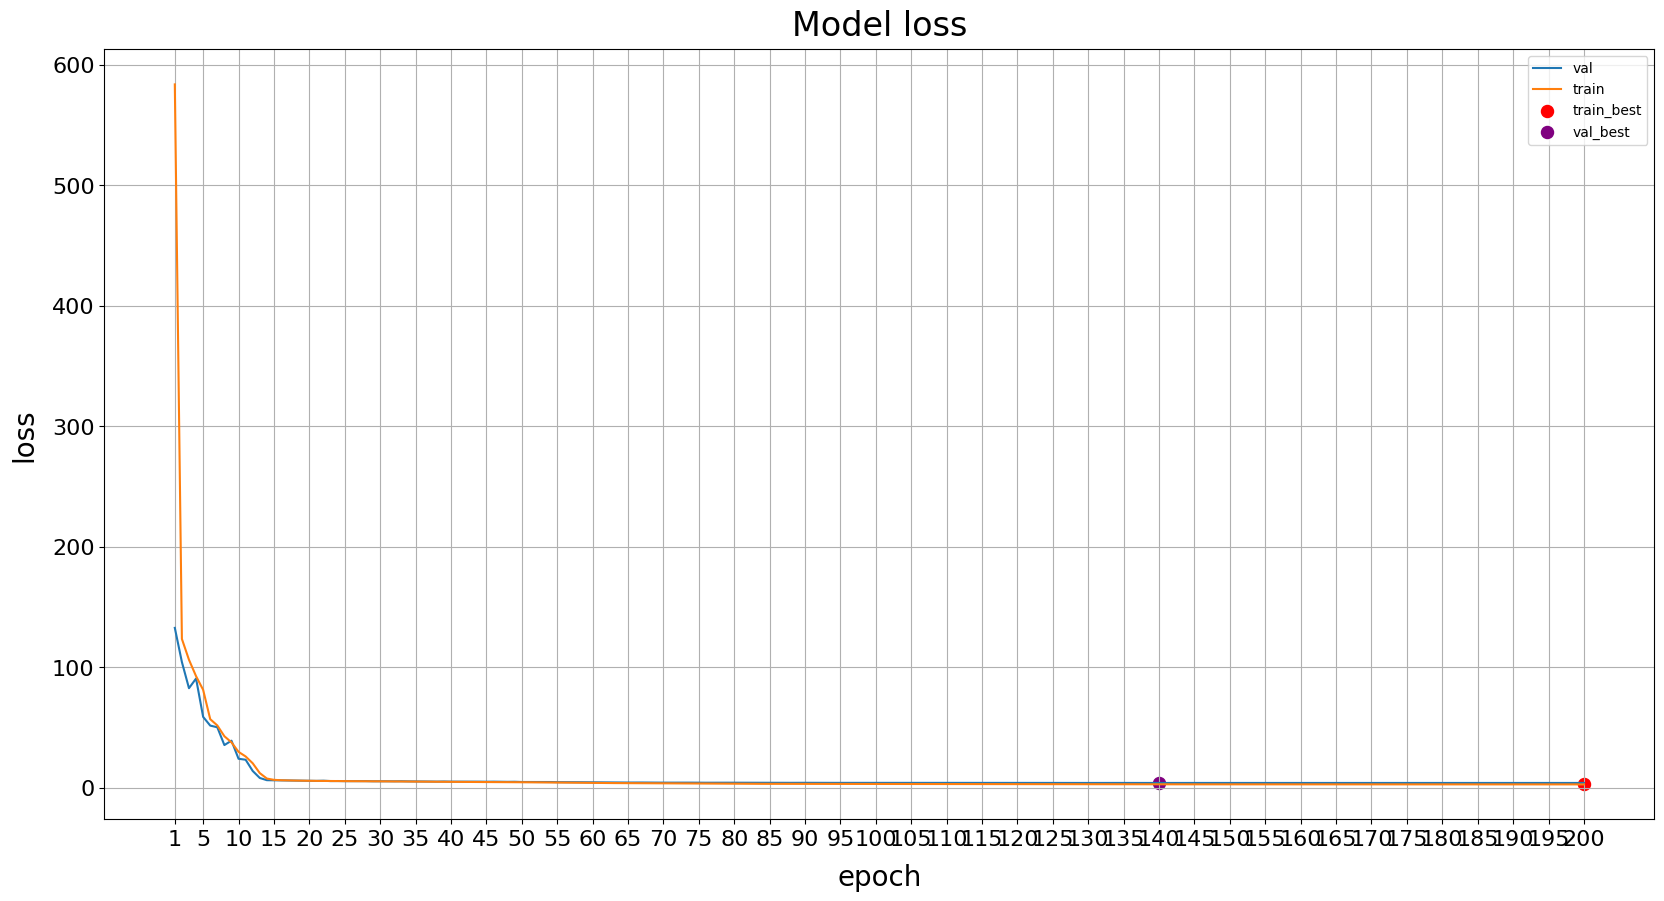

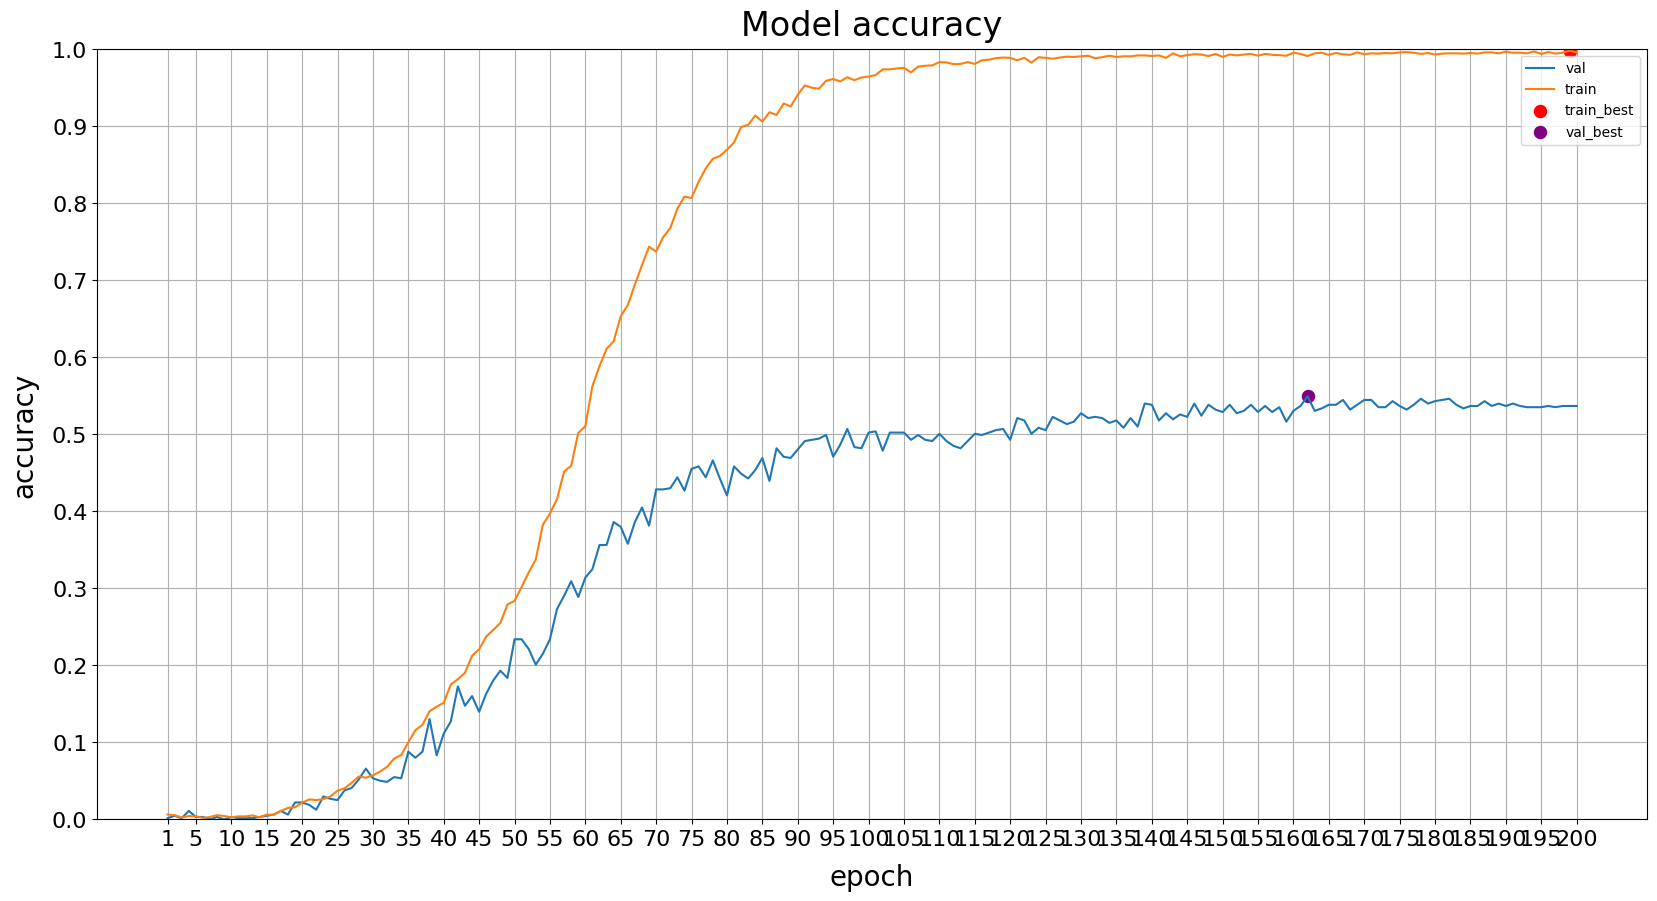

In [24]:
plot_history_metric('loss', f_best=np.argmin, save_path='/content/drive/MyDrive/loss_plot.png')
plot_history_metric('accuracy', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1), save_path='/content/drive/MyDrive/accuracy_plot.png')

In [25]:
model.evaluate(x=val_x, y=val_y)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.5510 - loss: 3.9312 - sparse_top_k_categorical_accuracy: 0.8082


[3.959839344024658, 0.5368916988372803, 0.8037676811218262]

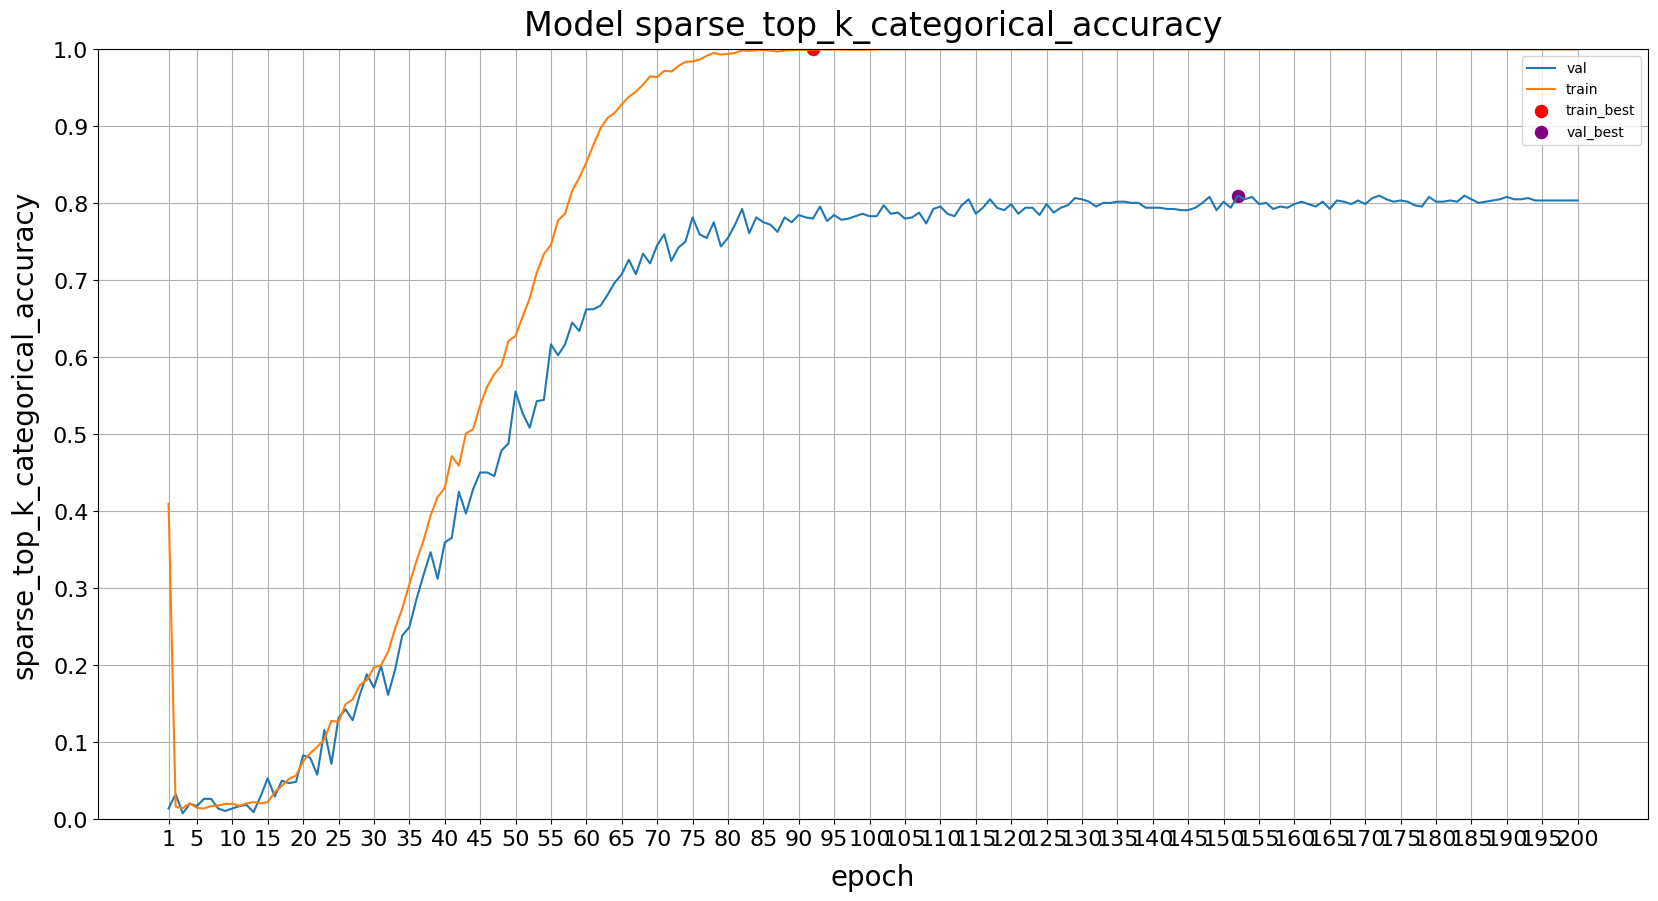

In [29]:
plot_history_metric('sparse_top_k_categorical_accuracy', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1), save_path='/content/drive/MyDrive/top_k_accuracy_plot.png')

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step
Recall: 0.5368916797488226


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


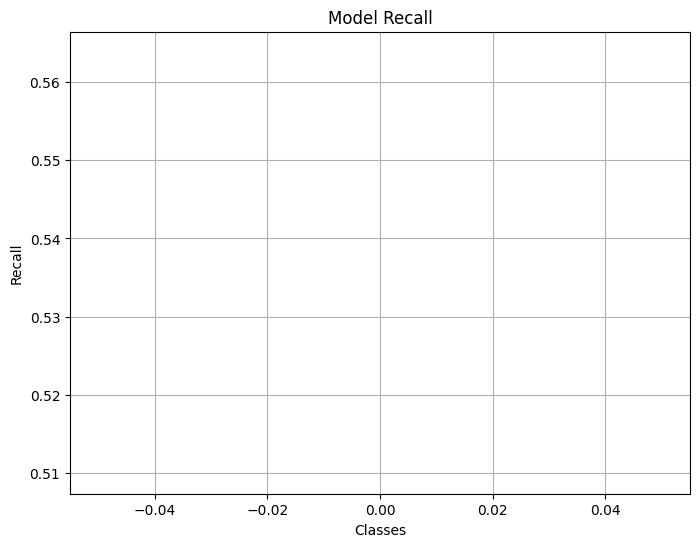

In [31]:
from sklearn.metrics import recall_score

y_pred = model.predict(val_x)
y_pred_classes = np.argmax(y_pred, axis=1)

recall = recall_score(val_y, y_pred_classes, average='weighted')

print(f"Recall: {recall}")

# Plot the recall
plt.figure(figsize=(8, 6))
plt.plot(recall)
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.title('Model Recall')
plt.grid(True)
plt.show()

In [26]:
signs = []
paths = []

root_folder = r"/content/landmarks_files_(alphabatically)_WLASL_300"

for class_name in os.listdir(root_folder):
    class_path = os.path.join(root_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    for file_name in os.listdir(class_path):
        phrase = class_name
        path = f"/content/landmarks_files_(alphabatically)_WLASL_300/{class_name}/{file_name}"
        signs.append(phrase)
        paths.append(path)
data = {
    'sign': signs,
    'path': paths,
}

train_df = pd.DataFrame(data)

# Converting Signs to Orginal Encodings
train_df['sign_encode'] = train_df['sign'].astype('category').cat.codes

# Dictionary to translate sign to ordinal encoded sign
SIGN_TO_ENCODE = train_df[['sign', 'sign_encode']].set_index('sign').squeeze().to_dict()
ENCODE_TO_SIGN = train_df[['sign_encode', 'sign']].set_index('sign_encode').squeeze().to_dict()


In [27]:
y_val_pred = model.predict(val_x, verbose=2).argmax(axis=1).astype(np.int32)
labels = [ENCODE_TO_SIGN.get(i, '').replace(' ', '_') for i in range(NUM_CLASSES)]

20/20 - 13s - 667ms/step


In [28]:
from sklearn.metrics import classification_report

# Get model predictions on validation set
y_val_pred_prob = model.predict(val_x, verbose=2)
y_val_pred = y_val_pred_prob.argmax(axis=1).astype(np.int32)
labels = [ENCODE_TO_SIGN.get(i, '').replace(' ', '_') for i in range(NUM_CLASSES)]

val_y = val_y.astype(np.int32)


# Generate classification report with specified labels parameter
class_report = classification_report(val_y, y_val_pred, labels=np.arange(NUM_CLASSES), target_names=labels)
print("Classification Report:")
print(class_report)


20/20 - 3s - 152ms/step
Classification Report:
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
       a_lot       0.00      0.00      0.00         2
     abdomen       1.00      0.67      0.80         3
        able       0.50      0.50      0.50         2
       about       0.67      1.00      0.80         2
       above       1.00      0.25      0.40         4
      accent       0.00      0.00      0.00         2
      accept       1.00      0.50      0.67         2
    accident       1.00      0.80      0.89         5
  accomplish       1.00      0.50      0.67         4
  accountant       0.00      0.00      0.00         0
      across       0.00      0.00      0.00         2
         act       0.33      1.00      0.50         1
      action       0.00      0.00      0.00         2
      active       0.00      0.00      0.00         6
    activity       0.17      0.50      0.25         2
       actor       1.00      1.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me